In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch 
import torchvision # torchvision package : 컴퓨터 비전을 위한 유명 데이터셋, 모델 아키텍처, 이미지 변형등을 포함
import torch.nn as nn # nn : neural netwroks (define class) attribute를 활용해 state를 저장하고 활용
import torch.optim as optim # 최적화 알고리즘
import torch.nn.functional as F # (define function) 인스턴스화 시킬 필요없이 사용 가능
from PIL import Image
from torchvision import transforms, datasets # transforms : 데이터를 조작하고 학습에 적합하게 만듦.
from torch.utils.data import Dataset, DataLoader
# dataset : 샘플과 정답(label)을 저장
# DataLoader : Dataset 을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감싼다.

In [3]:
epochs = 10 # 훈련 반복수
batch_size = 512 # 배치 크기

device = ("cuda" if torch.cuda.is_available() else "cpu") # device 정의
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] # 총 10개의 클래스

print(torch.__version__)
print(device)

# 결과
# 1.10.0+cu111
# cuda

1.13.1
cpu


In [4]:
transform = transforms.Compose([
    transforms.Resize(227), # Compose : transforms 리스트 구성
    # 227x227 : input image(in alexnet) but fashionMNIST's input image : 28x28
    transforms.ToTensor()]) # ToTensor : PIL image or numpy.ndarray를 tensor로 바꿈

training_data = datasets.FashionMNIST(
    root="data", # data가 저장될 경로(path)
    train=True, # training dataset
    download=True, # 인터넷으로부터 데이터 다운
    transform=transform # feature 및 label 변환(transformation) 지정
)

validation_data = datasets.FashionMNIST(
    root="data",
    train=False, # test dataset
    download=True,
    transform=transform
)

In [6]:
# (class) DataLoader(dataset, batch_size, shuffle, ...)
training_loader = DataLoader(training_data, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=True)

T-shirt/top


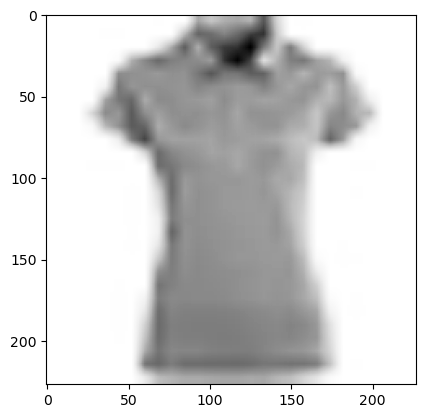

In [8]:
# helper function to show an image
def matplotlib_imshow(img):
    img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(npimg, cmap="Greys")
    
# get some random training images
dataiter = iter(training_loader) # iter(호출가능한객체, 반복을끝낼값)
images, labels = next(dataiter) # next() : 반복할 수 있을 때는 해당 값을 출력하고, 반복이 끝났을 때는 기본값을 출력

# create grid of images
img_grid = torchvision.utils.make_grid(images[0]) # make_grid : 이미지의 그리드 생성

# show images & labels
matplotlib_imshow(img_grid)
print(class_names[labels[0]])

In [9]:
class fashion_mnist_alexnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
        
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4, padding=0), 
            # 4D tensor : [number_of_kernels, input_channels, kernel_width, kernel_height] 
            # = 96x1x11x11
            # input size : 1x227x227
            # input size 정의 : (N, C, H, W) or (C, H, W)
            # W' = (W-F+2P)/S + 1
            # 55x55x96 feature map 생성 (55는 (227-11+1)/4)
            # 최종적으로 227 -> 55
            nn.ReLU(), # 96x55x55
            nn.MaxPool2d(kernel_size=3, stride=2) 
            # 55 -> (55-3+1)/2 = 26.5 = 27
            # 96x27x27 feature map 생성

        ) 
        self.conv2 = nn.Sequential(
            nn.Conv2d(96, 256, 5, 1, 2), # in_channels: 96, out_channels: 256, kernel_size=5x5, stride=1, padding=2
            # kernel 수 = 48x5x5 (드롭아웃을 사용했기 때문에 96/2=48) 형태의 256개
            # 256x27x27
            nn.ReLU(),
            nn.MaxPool2d(3, 2) # 27 -> 13
            # 256x13x13
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU() # 13 유지
            # 384x13x13
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU() # 13 유지
            # 384x13x13
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2) # 13 -> 6
            # 256x6x6
        )
        
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x): # input size = 3x227x227
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out) # 64x4096x1x1
        out = out.view(out.size(0), -1) # 64x4096
        
        out = F.relu(self.fc1(out))
        out = F.dropout(out, 0.5)
        out = F.relu(self.fc2(out))
        out = F.dropout(out, 0.5)
        out = self.fc3(out)
        out = F.log_